In [451]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [452]:
def f(x):
    return x**2 +3*x + 2

In [453]:
f(2)

12

In [454]:
xs = np.arange(-10, 10, 0.25)
ys = f(xs)
ys

array([ 72.    ,  67.8125,  63.75  ,  59.8125,  56.    ,  52.3125,
        48.75  ,  45.3125,  42.    ,  38.8125,  35.75  ,  32.8125,
        30.    ,  27.3125,  24.75  ,  22.3125,  20.    ,  17.8125,
        15.75  ,  13.8125,  12.    ,  10.3125,   8.75  ,   7.3125,
         6.    ,   4.8125,   3.75  ,   2.8125,   2.    ,   1.3125,
         0.75  ,   0.3125,   0.    ,  -0.1875,  -0.25  ,  -0.1875,
         0.    ,   0.3125,   0.75  ,   1.3125,   2.    ,   2.8125,
         3.75  ,   4.8125,   6.    ,   7.3125,   8.75  ,  10.3125,
        12.    ,  13.8125,  15.75  ,  17.8125,  20.    ,  22.3125,
        24.75  ,  27.3125,  30.    ,  32.8125,  35.75  ,  38.8125,
        42.    ,  45.3125,  48.75  ,  52.3125,  56.    ,  59.8125,
        63.75  ,  67.8125,  72.    ,  76.3125,  80.75  ,  85.3125,
        90.    ,  94.8125,  99.75  , 104.8125, 110.    , 115.3125,
       120.75  , 126.3125])

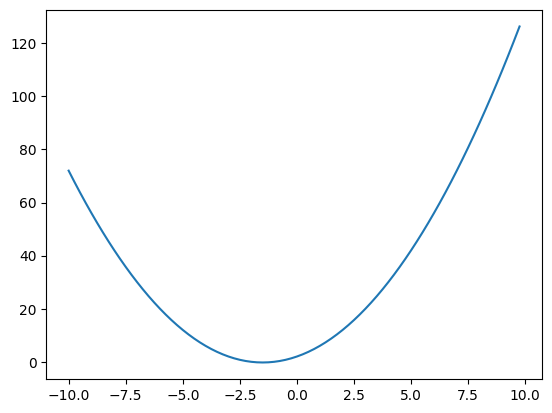

In [455]:
plt.plot(xs, ys)

## Derivates

In [456]:
h = 0.0001
def derivative(x):
    return (f(x+h)-f(x))/h

In [457]:
derivative(2) # 2x + 3 = 2*2 + 3 = 7

7.000100000027487

In [458]:
derivative(3) # 2x + 3 = 2*3 + 3 = 9

9.000100000022826

## Complex parameter derivation (partial derivatives)

In [459]:
def pf(x,y,z):
    return x*y+z

In [460]:
def der(x,y,z,dx,dy,dz):
    return (pf(x+dx,y+dy,z+dz)-pf(x,y,z))/(dx+dy+dz)

In [461]:
der(2,3,4,h,0,0) # 3 (d(d1)/dx) = (y) = 3

3.000000000010772

In [462]:
der(2,3,4,0,h,0) # 2 (d(d1)/dy=x=2)

1.9999999999953388

In [463]:
der(2,3,4,0,0,h) # 1 (d(d1)/dz=1)

0.9999999999976694

## Start of Understanding classes and objects

In [464]:
class Value:

    def __init__(self,data,_children=(),_op=(),label=''): # _children is a tuple
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.grad = 0.0
    
    def __repr__(self):
        return f"Value (data={self.data} label={self.label})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self,other), "+")
        def _backward():
            self.grad =  1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other), "*")
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
    def tanh(self):
        out = Value(math.tanh(self.data), (self,), "tanh")
        def _backward():
            self.grad = (1.0 - (out.data ** 2)) * out.grad
        out._backward = _backward
        return out
    def backward(self):
        # self.grad = 1.0
        # visited = set()
        # def _backward(v):
        #     if v not in visited:
        #         visited.add(v)
        #         v._backward()
        #         [ _backward(child) for child in v._prev ]
        # _backward(self)
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                [build_topo(child) for child in v._prev]
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()

In [465]:
Value(3)  # Python internally calls obj.__repr__() where obj = Value(3)

Value (data=3 label=)

In [466]:
Value(3) + Value(4) # Python internally calls obj.__add__(other) where obj = Value(3) and other = Value(4)

Value (data=7 label=)

In [467]:
a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c =  Value(10.0,label='c')
e = a*b # Python internally calls obj.__mul__(other) where obj = Value(3) and other = Value(4)
e.label = 'e'
d = c +e # Python internally calls obj.__mul__(other) where obj = Value(3) and other = Value(4)
d.label = 'd'
f = Value(-2.0,label='f')
L = d * f # Python internally calls obj.__mul__(other) where obj = Value(3) and other = Value(4)
L.label = 'L'

In [468]:
e._prev

{Value (data=-3.0 label=b), Value (data=2.0 label=a)}

In [469]:
e.data

-6.0

In [470]:
e.label

'e'

## Showcase all operation in Graphs

In [471]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % ( n.label,n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

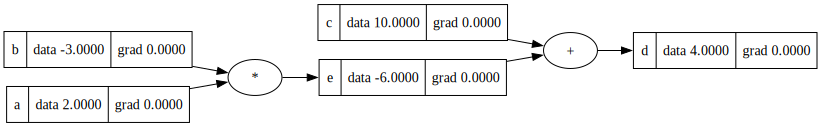

In [472]:
draw_dot(d)

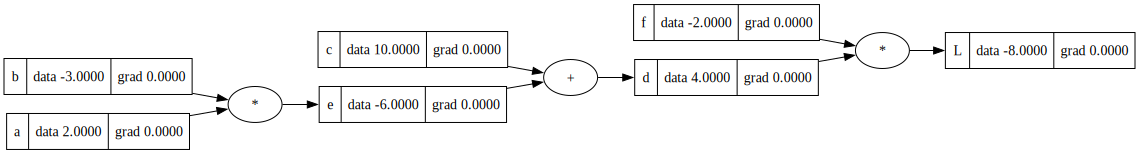

In [473]:
draw_dot(L)

## Backpropogation

In [474]:
# def backward(root):
#   # perform a backward pass on the graph
#   root.grad = 1.0
#   visited = set()
#   def backward_dfs(v):
#     if v in visited:
#       return
#     visited.add(v)
#     for child in v._prev:
#       # apply the chain rule to get the gradient of the child with respect to this node
#       child.grad += v.grad * derivative(child.data)
#       backward_dfs(child)
#   backward_dfs(root)

# backward(L)

In [475]:
e.data

-6.0

In [476]:
def fnc(da,db,dc,dd,de,df,dL):
    a = Value(2+da,label='a')
    b = Value(-3+db,label='b')
    c =  Value(10+dc,label='c')
    e = a*b
    e.data += de
    e.label = 'e'
    d = c +e
    d.data += dd
    d.label = 'd'
    f = Value(-2+df,label='f')
    L = d * f
    L.label = 'L'
    L.data += dL
    return L
fnc(0,0,0,0,0,0,0).data

-8

In [477]:
dL = (fnc(0,0,0,0,0,0,h).data - L.data)/h
L.grad = dL
L.grad

0.9999999999976694

In [478]:
df = (fnc(0,0,0,0,0,h,0).data - L.data)/h
f.grad = df
f.grad

3.9999999999995595

In [479]:
de = (fnc(0,0,0,0,h,0,0).data - L.data)/h
e.grad = de
e.grad

-1.9999999999953388

In [480]:
dd = (fnc(0,0,0,h,0,0,0).data - L.data)/h
d.grad = dd
d.grad

-1.9999999999953388

In [481]:
dc = (fnc(0,0,h,0,0,0,0).data - L.data)/h
c.grad = dc
c.grad

-1.9999999999953388

In [482]:
db = (fnc(0,h,0,0,0,0,0).data - L.data)/h
b.grad = db
b.grad

-4.000000000008441

In [483]:
da = (fnc(h,0,0,0,0,0,0).data - L.data)/h
a.grad = da
a.grad

6.000000000021544

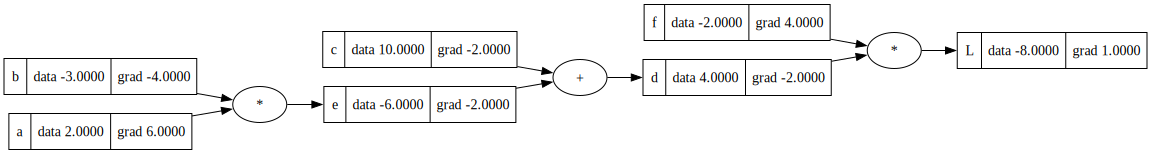

In [484]:
draw_dot(L)

In [485]:
def forward_pass(step):
    a.data += step * a.grad
    b.data += step * b.grad
    c.data += step * c.grad
    f.data += step * f.grad

    e = a*b
    d = c + e
    L = d * f
    return L.data

In [486]:
forward_pass(0.01)

-7.286495999998483

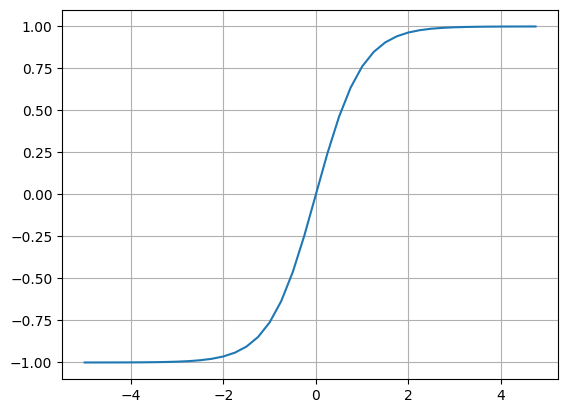

In [487]:
plt.plot(np.arange(-5,5,0.25),np.tanh(np.arange(-5,5,0.25))); plt.grid()

## Backward Propogation with neuron

In [488]:
x1 = Value(2.0,label='x1')
w1 = Value(-3.0,label='w1')
x1w1 = x1*w1
x1w1.label = 'x1w1'
x2 = Value(0.0,label='x2')
w2 = Value(1.0,label='w2')
x2w2 = x2*w2
x2w2.label = 'x2w2'
b = Value(6.8813735870195432,label='b')
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1+x2w2'

n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'o'


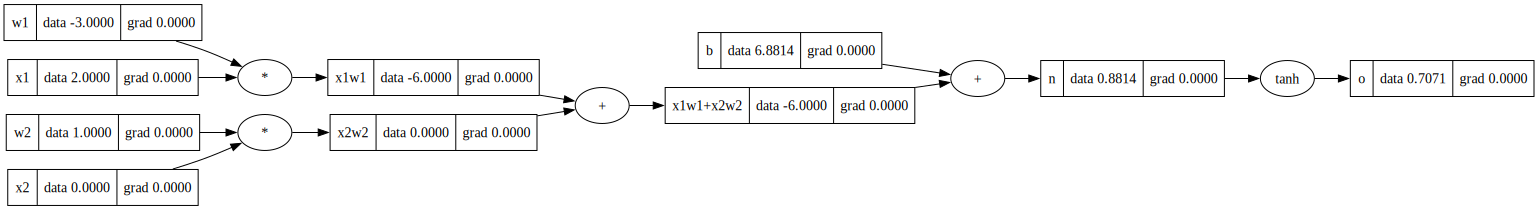

In [489]:
draw_dot(o)

In [490]:
o.grad = 1.0

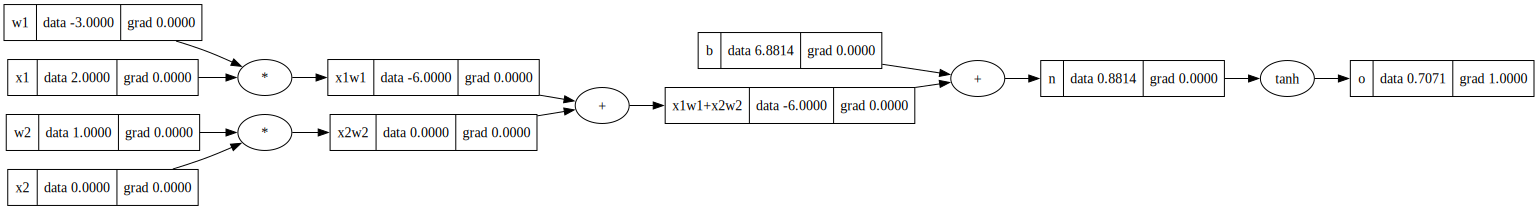

In [491]:
draw_dot(o)

In [492]:
o._backward()

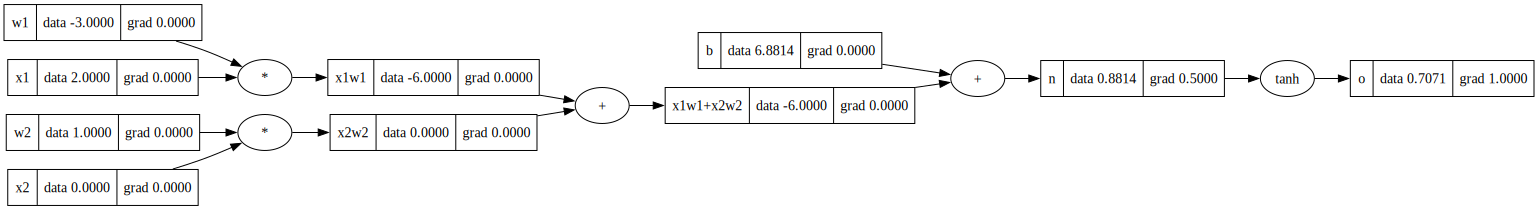

In [493]:
draw_dot(o)

In [494]:
n._backward()

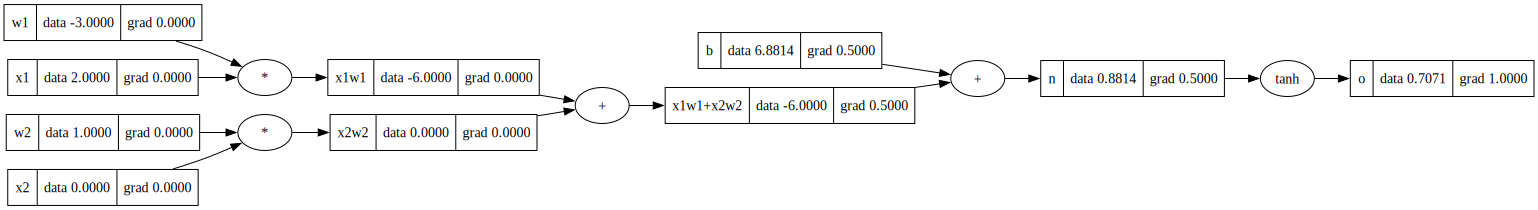

In [495]:
draw_dot(o)

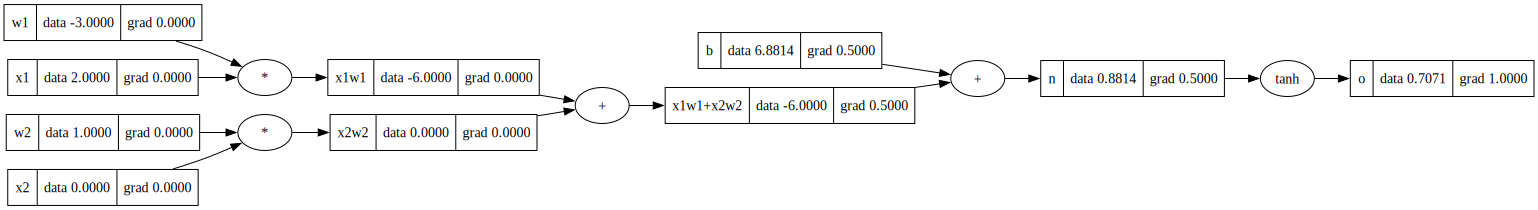

In [496]:
b._backward()
draw_dot(o)

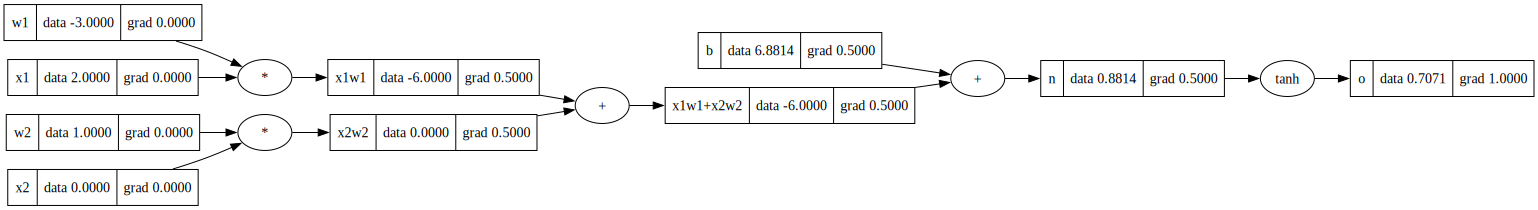

In [497]:
x1w1x2w2._backward()
draw_dot(o)

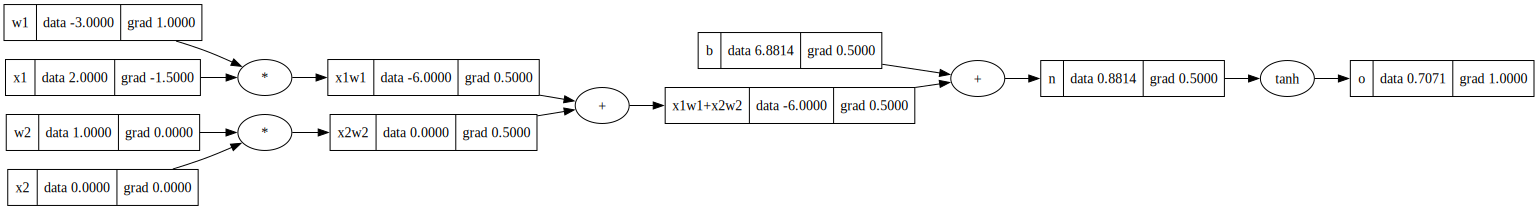

In [498]:
x1w1._backward()
draw_dot(o)

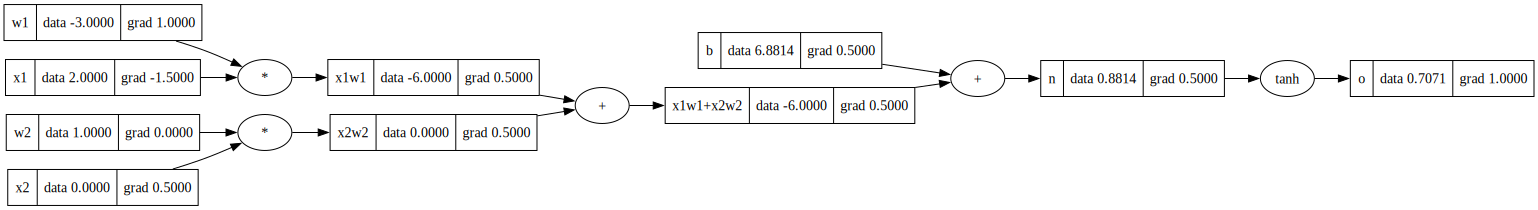

In [499]:
x2w2._backward()
draw_dot(o)

In [500]:
topo_order = []
visited = set()
def topological_sort(v):
    if v not in visited:
        visited.add(v)
    for child in v._prev:
        topological_sort(child)
    topo_order.append(v)
topological_sort(o)
topo_order

[Value (data=6.881373587019543 label=b),
 Value (data=0.0 label=x2),
 Value (data=1.0 label=w2),
 Value (data=0.0 label=x2w2),
 Value (data=2.0 label=x1),
 Value (data=-3.0 label=w1),
 Value (data=-6.0 label=x1w1),
 Value (data=-6.0 label=x1w1+x2w2),
 Value (data=0.8813735870195432 label=n),
 Value (data=0.7071067811865476 label=o)]

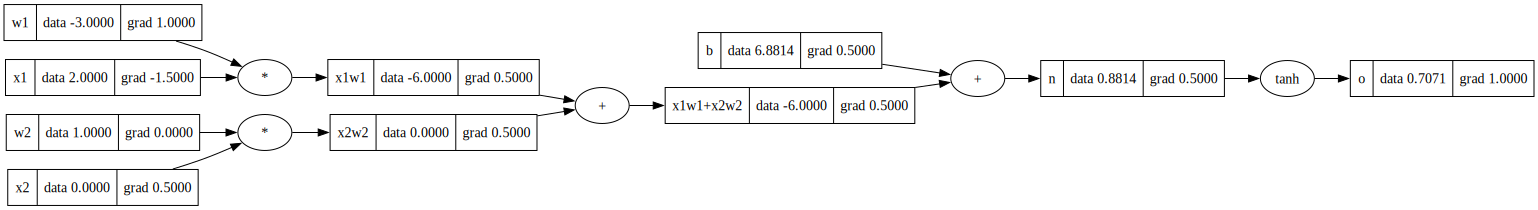

In [501]:
o.backward()
draw_dot(o)

### Bug alert

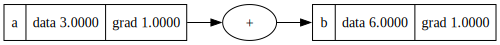

In [502]:
a = Value(3.0,label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

#### Value class has an bug as we have not considered the case where one variable is not contributing to many operations

##### To overcome this we have to add + the self.grad in itself

### Correct Value Class

In [503]:
class Value:

    def __init__(self,data,_children=(),_op=(),label=''): # _children is a tuple
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.grad = 0.0
    
    def __repr__(self):
        return f"Value (data={self.data} label={self.label})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other) # if other is not a Value object, convert it to one with the same data
        out = Value(self.data + other.data, (self,other), "+")
        def _backward():
            self.grad +=  1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other) # if other is not a Value object, convert it to one with the same data
        out = Value(self.data * other.data, (self,other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self,other):
        return self * other
    
    def __truediv__(self,other):
        return self * (other ** -1)
    
    def __pow__(self,other):
        assert isinstance(other, (int,float)), "Exponent must be a scalar"
        out = Value(self.data ** other, (self,), f"**{other}")
        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        out = Value(math.tanh(self.data), (self,), "tanh")
        def _backward():
            self.grad += (1.0 - (out.data ** 2)) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        out = Value(math.exp(self.data), (self,), "exp")
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        # self.grad = 1.0
        # visited = set()
        # def _backward(v):
        #     if v not in visited:
        #         visited.add(v)
        #         v._backward()
        #         [ _backward(child) for child in v._prev ]
        # _backward(self)
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                [build_topo(child) for child in v._prev]
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()

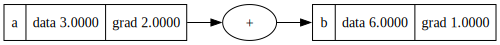

In [504]:
a = Value(3.0,label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

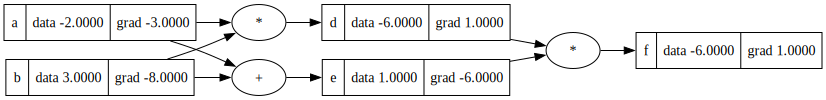

In [505]:
a= Value(-2.0, label='a') 
b= Value(3.0, label='b') 
d=a*b ; d.label = 'd' 
e=a+b ; e.label= 'e' 
f=d * e ; f.label = 'f' 
f.backward() 
draw_dot(f)

In [506]:
a + 1; # Python internally calls obj.__add__(other) where obj = Value(3) and other = Value(4)

In [507]:
2 * a; # Python internally calls obj.__mul__(other) where obj = Value(3) and other = Value(4)

In [508]:
a / b

Value (data=-0.6666666666666666 label=)

In [509]:
import torch

In [510]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [511]:
import random

In [512]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [513]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value (data=0.8465255880819986 label=)

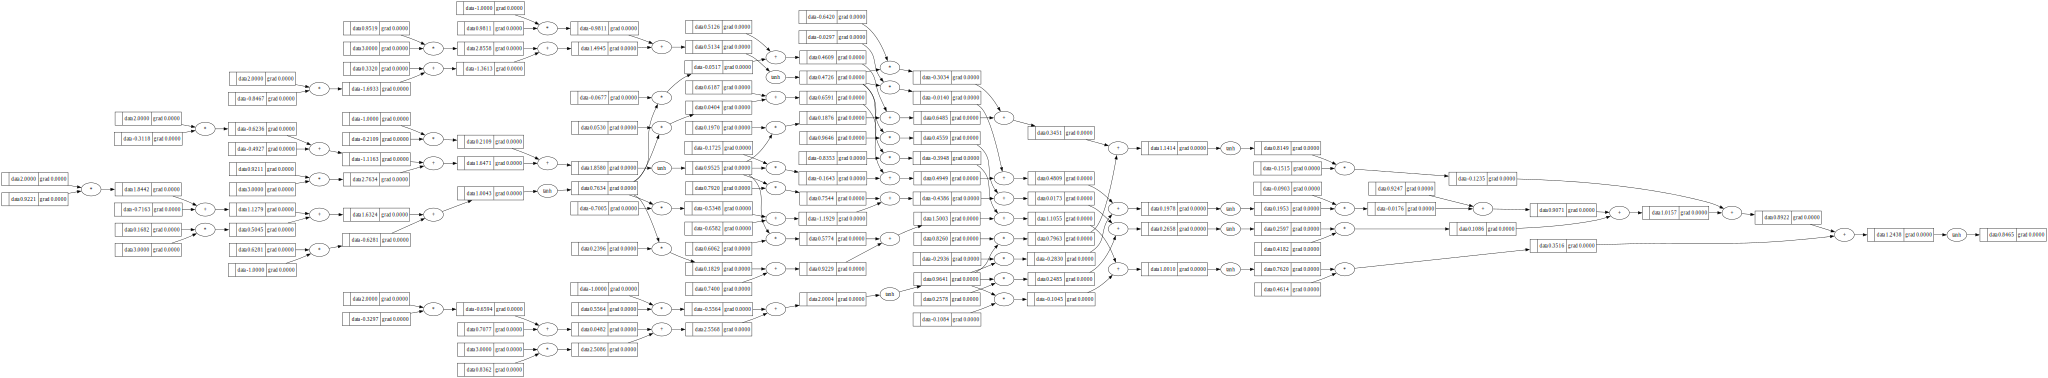

In [514]:
draw_dot(n(x))

In [515]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value (data=0.8465255880819986 label=),
 Value (data=0.6550884461858648 label=),
 Value (data=0.7125923165682307 label=),
 Value (data=0.7313026152318216 label=)]

In [516]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value (data=5.768042887161314 label=)

In [517]:
n.layers[0].neurons[0].w[0].grad

0.0

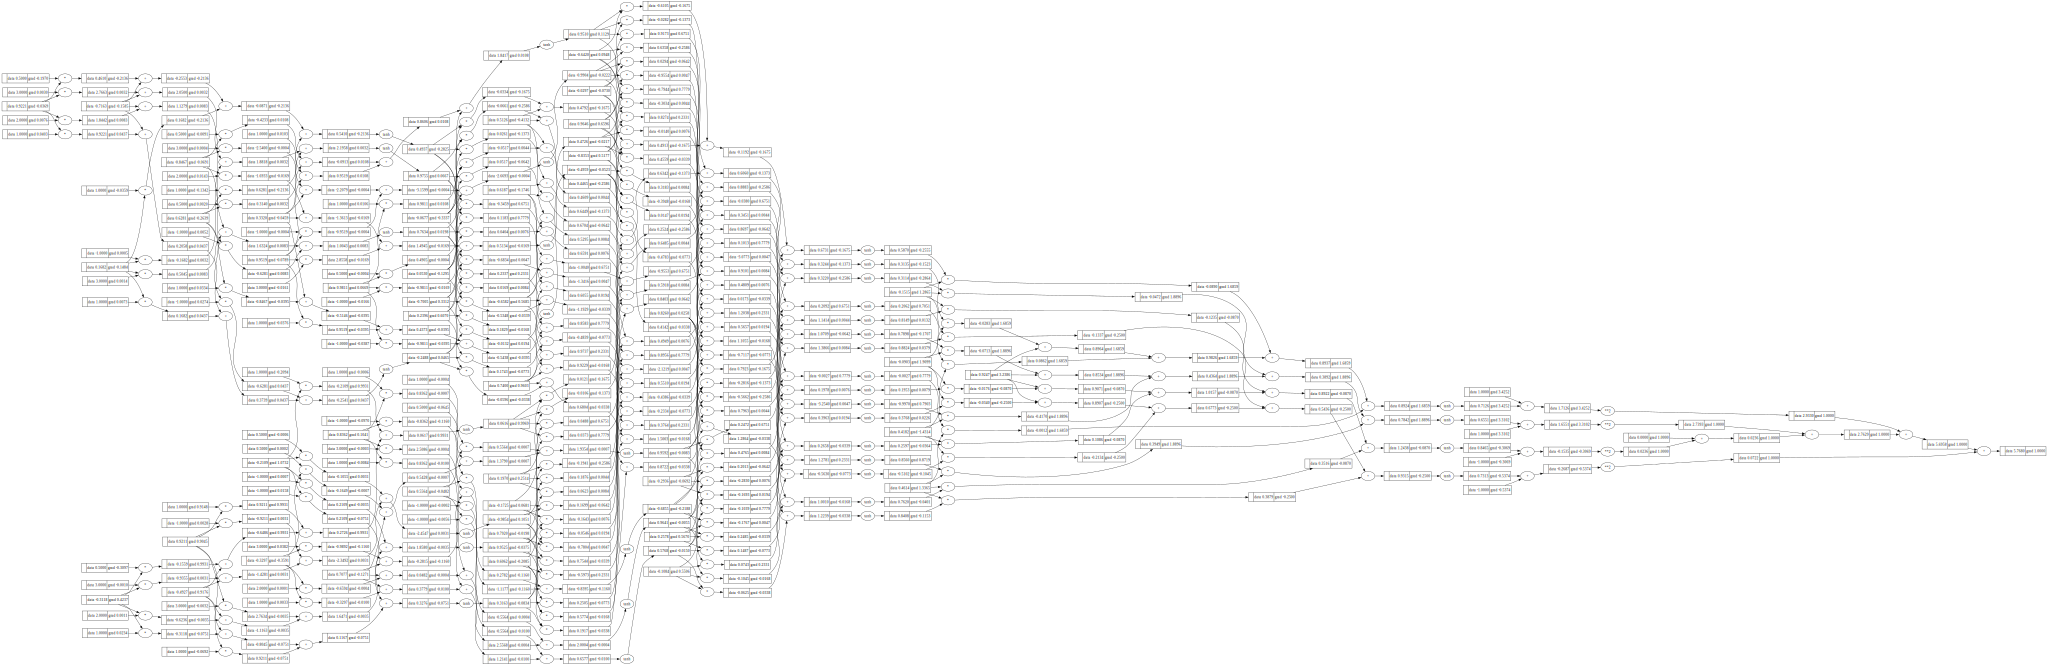

In [518]:
loss.backward()
draw_dot(loss)

In [519]:
len(n.parameters())

41

In [520]:
# n.layers[0].neurons[0].w[0].data

In [521]:
# for p in n.parameters():
#   p.data += -0.01 * p.grad


In [522]:
# n.layers[0].neurons[0].w[0].data

In [ ]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 5.768042887161314
1 2.9842328277067467
2 1.4401627831752803
3 0.8909858897789528
4 0.23372750321923702
5 0.1088326278920752
6 0.08534815351055151
7 0.07008756109952162
8 0.05932835017260637
9 0.05133322884140905
10 0.04516271145807742
11 0.040260718941078674
12 0.036276253038752926
13 0.03297662444411112
14 0.03020143918965747
15 0.02783655175334427
16 0.02579853419281737
17 0.02402501223772795
18 0.0224684331084493
19 0.021091921954052104


In [524]:
ypred

[Value (data=0.9408218968890248 label=),
 Value (data=-0.9112539303273348 label=),
 Value (data=-0.9331765069974218 label=),
 Value (data=0.9275525710129908 label=)]

In [525]:
n.parameters()

[Value (data=0.7304316573547459 label=),
 Value (data=-0.0024001341783351 label=),
 Value (data=1.0069537569971316 label=),
 Value (data=-0.760930144007082 label=),
 Value (data=-0.2228824978681772 label=),
 Value (data=0.8434514552622515 label=),
 Value (data=-0.8828115352737403 label=),
 Value (data=-0.6212282401323601 label=),
 Value (data=-0.6755419846685915 label=),
 Value (data=1.1390720896719888 label=),
 Value (data=0.8260597602549179 label=),
 Value (data=0.46509997295591443 label=),
 Value (data=-0.14175046393825758 label=),
 Value (data=0.8172370953962885 label=),
 Value (data=0.5486308589782419 label=),
 Value (data=0.7904900502976137 label=),
 Value (data=0.2497583636357711 label=),
 Value (data=-0.468209027618887 label=),
 Value (data=-0.007653997169096204 label=),
 Value (data=-0.38558106116280966 label=),
 Value (data=0.5828262663308137 label=),
 Value (data=-0.9002325973609975 label=),
 Value (data=1.083413105349889 label=),
 Value (data=0.6858572654163155 label=),
 Va

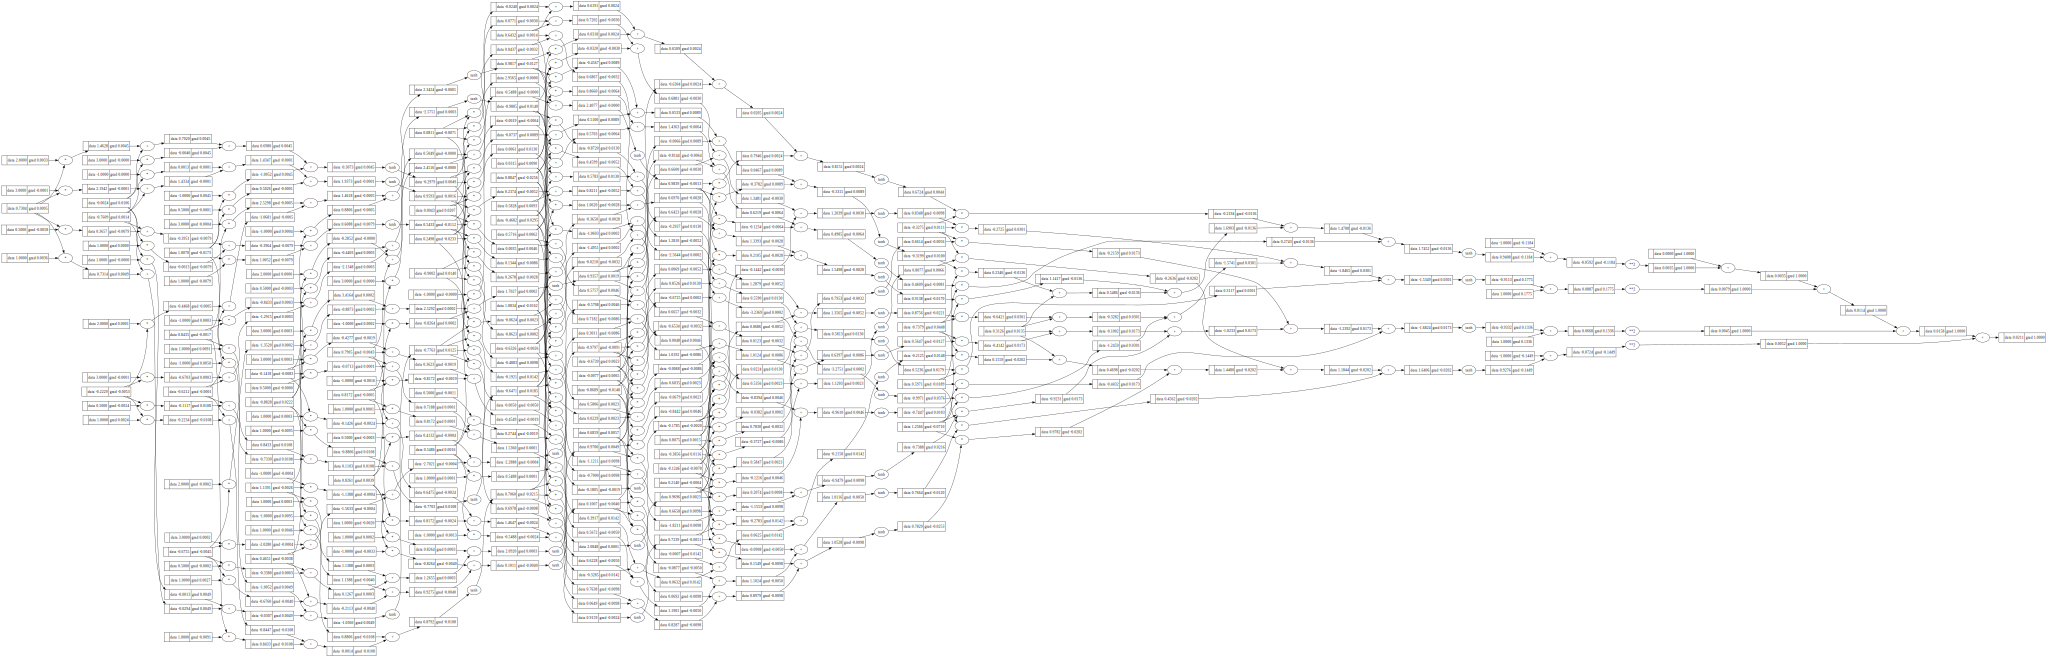

In [527]:
draw_dot(loss)